<a href="https://colab.research.google.com/github/eghib22/Store-Sales-Forecasting/blob/main/model_experiment_DLinear_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

! mkdir ~/.kaggle
from google.colab import files
files.upload()
!mv "kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle/

!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
! unzip walmart-recruiting-store-sales-forecasting
!unzip '*.csv.zip'
!unzip '*.csv.zip'


!pip install -q neuralforecast wandb

import pandas as pd
import numpy as np
import joblib
import wandb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
from datetime import datetime
import torch
from torch.utils.data import DataLoader, Dataset
from neuralforecast.models import DLinear
import os, joblib
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from neuralforecast.core import NeuralForecast
from neuralforecast.models import DLinear


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle.json
total 4
-rw------- 1 root root 71 Jul 16 10:07 kaggle.json
walmart-recruiting-store-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  walmart-recruiting-store-sales-forecasting.zip
replace features.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: features.csv.zip        
replace sampleSubmission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv.zip  
replace stores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: stores.csv              
replace test.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv.zip            
replace train.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv.zip           
Archive:  sampleSubmission.csv.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv    

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]

In [2]:
wandb.init(
project="Store-Sales-Forecasting",
entity="agasi22-free-university-of-tbilisi-",
name="DLinear_pipeline",
config={
"model": "DLinear",
"horizon": 39,
"input_size": 400,
"epochs": 500,
"batch_size": 64,
"lr": 1e-3,
}
)
config = wandb.config


wandb: Currently logged in as: agasi22 (agasi22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
_df_train = pd.read_csv("train.csv", parse_dates=['Date'])
_df_feat = pd.read_csv("features.csv", parse_dates=['Date'])
_df_store = pd.read_csv("stores.csv")


df = (
_df_train
.merge(_df_feat, on=['Store','Date','IsHoliday'], how='left')
.merge(_df_store, on='Store', how='left')
)


df['y'] = df['Weekly_Sales'].clip(lower=0)
df['unique_id'] = df['Store'].astype(str) + '_' + df['Dept'].astype(str)

df_nf = df[['unique_id','Date','y']].rename(columns={'Date':'ds'})


In [7]:

class TrainTestDF2NF(BaseEstimator, TransformerMixin):
    def __init__(self, features_df, stores_df):
        self.features_df = features_df
        self.stores_df   = stores_df

    def fit(self, X, y=None):

        return self

    def transform(self, X):
        if set(['unique_id','ds','y']).issubset(X.columns):
            return X


        df_raw = (
            X
            .merge(self.features_df, on=['Store','Date','IsHoliday'], how='left')
            .merge(self.stores_df,   on='Store',            how='left')
        )

        df_raw['y'] = np.nan
        df_raw['unique_id'] = df_raw['Store'].astype(str) + '_' + df_raw['Dept'].astype(str)
        return df_raw[['unique_id','Date','y']].rename(columns={'Date':'ds'})


class DLinearNF(BaseEstimator, RegressorMixin):
    def __init__(self, h, input_size, freq='W-FRI', lr=1e-3, epochs=500, batch_size=64):
        self.h          = h
        self.input_size = input_size
        self.freq       = freq
        self.lr         = lr
        self.epochs     = epochs
        self.batch_size = batch_size

    def fit(self, X, y=None):

        model = DLinear(
            h=self.h,
            input_size=self.input_size,
            learning_rate=self.lr,
            max_steps=self.epochs,
            batch_size=self.batch_size,
            random_seed=42,
            start_padding_enabled=True
        )
        nf = NeuralForecast(models=[model], freq=self.freq)
        nf.fit(df=X)
        self.nf    = nf
        self.model = model
        return self

    def predict(self, X=None):

        preds = self.nf.predict()
        return preds.rename(columns={'DLinear':'y_pred'})


pipeline = Pipeline([
    ('to_df_nf', TrainTestDF2NF(_df_feat, _df_store)),
    ('dlinear',  DLinearNF(
        h=config.horizon,
        input_size=config.input_size,
        freq='W-FRI',
        lr=config.lr,
        epochs=config.epochs,
        batch_size=config.batch_size
    ))
])


cutoff  = df_nf['ds'].max() - pd.Timedelta(days=28)
train_nf = df_nf[df_nf['ds'] <= cutoff]
val_nf   = df_nf[df_nf['ds'] >  cutoff]

pipeline.fit(train_nf)
val_preds = pipeline.predict(val_nf)


val_eval = val_nf.merge(val_preds, on=['unique_id','ds'])
holiday_flags = df[['Date', 'IsHoliday']].drop_duplicates()
val_eval = val_eval.merge(holiday_flags, left_on='ds', right_on='Date', how='left')

val_eval['weight'] = val_eval['IsHoliday'].apply(lambda x: 5 if x else 1)


wmae = np.sum(val_eval['weight'] * np.abs(val_eval['y'] - val_eval['y_pred'])) / np.sum(val_eval['weight'])

print(f"Validation WMAE: {wmae:.3f}")
wandb.log({"WMAE": wmae})


pipeline.fit(df_nf)
ART_DIR = 'dlinear_nf_artifact'
os.makedirs(ART_DIR, exist_ok=True)
joblib.dump(pipeline, f"{ART_DIR}/dlinear_pipeline.pkl")
artifact = wandb.Artifact("walmart_dlinear_pipeline", type="model")
artifact.add_file(f"{ART_DIR}/dlinear_pipeline.pkl")
wandb.log_artifact(artifact)
wandb.finish()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | linear_trend  | Linear        | 15.6 K | train
5 | linear_season | Linear        | 15.6 K | train
--------------------------------------------------------
31.3 K    Trainable params
0         Non-trainable params
31.3 K    Total params
0.125     Total esti

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 42


Validation WMAE: 2085.020


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | linear_trend  | Linear        | 15.6 K | train
5 | linear_season | Linear        | 15.6 K | train
--------------------------------------------------------
31.3 K    Trainable params
0         Non-trainable params
31.3 K    Total params
0.125     Total estimated model params size (MB)
8         Modules in tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


WMAE,▁
WMAE,2085.02015


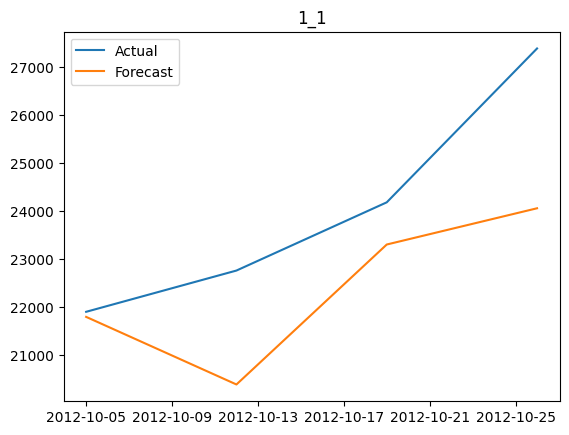

In [8]:
import matplotlib.pyplot as plt

store_dept = '1_1'  # მაგალითად
df_plot = val_eval[val_eval['unique_id'] == store_dept]

plt.plot(df_plot['ds'], df_plot['y'], label='Actual')
plt.plot(df_plot['ds'], df_plot['y_pred'], label='Forecast')
plt.title(store_dept)
plt.legend()
plt.show()